In [1]:
using Pkg
Pkg.activate(".")
using MiniOps
using Random, LinearAlgebra
using Plots


  Activating project at `~/MiniOps`
[ Info: Precompiling MiniOps [af2dcb7c-2195-40b8-81d3-f942299158c3] (cache misses: include_dependency fsize change (2), mismatched flags (2))


In [2]:
P=pad_op((3,3))

LoadError: MethodError: no method matching pad_op(::Tuple{Int64, Int64})
The function `pad_op` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  pad_op(::NTuple{N, Int64}, [91m::NTuple{N, Int64}[39m, [91m::NTuple{N, Int64}[39m) where N
[0m[90m   @[39m [35mMiniOps[39m [90m~/MiniOps/src/[39m[90m[4mfftops.jl:83[24m[39m
[0m  pad_op([91m::AbstractArray[39m, [91m::NTuple{N, Int64}[39m, [91m::NTuple{N, Int64}[39m) where N
[0m[90m   @[39m [35mMiniOps[39m [90m~/MiniOps/src/[39m[90m[4mfftops.jl:110[24m[39m


In [49]:

Random.seed!(0)

# Y = A * X Multichannel convolution
# X'= A'* Y Multichannel one-side croscorrlation

h  = [1.0, 2.0, -1.0] # Wavelet 

A  = conv1d_cols_op(h)

nt, ntr = 50, 100
X  = randn(nt, ntr)                     # test input

Y  = A * X

Z  = randn(size(Y))                     # test output

ok, err = adjoint_test(A, X, Z)         # <AX,Z> = <A'Z,X>
@show ok err;



ok = true
err = 1.8364041408825356e-16


In [58]:
h = randn(14)
B = conv1d_op(h)       #B*x is convolution of x with h

result = linearity_test(B, randn(10), randn(10); ntests=3, tol=1e-10)
println(B.name, " Linearity test : " , result)

result = adjoint_test(B, randn(10), randn(10+14-1); tol=1e-10)
println(B.name, " Adjoint test   : ", result)

e = opnorm_power(B, randn(10); niter=20)
println(B.name, " Maximum Eig    : ", e)

Sc = scaling_op(3.0)
result = is_selfadjoint(Sc, randn(20); tol=1e-10)
println(Sc.name, " Self adjoint ? ", result)

Sc = scaling_op(0.3)
T=Sc*Sc
T.name


conv1d Linearity test : (true, 1.810994494866626e-16)
conv1d Adjoint test   : (true, 1.6855762386703605e-16)
conv1d Maximum Eig    : 8.452082481290981
scaling Self adjoint ? (true, 0.0)


Symbol("scaling*scaling")

In [59]:
B = fft_op()

result = linearity_test(B, randn(128), randn(128); ntests=3, tol=1e-10)
println(B.name, " Linearity test : " , result)

result = adjoint_test(B, randn(128), randn(128); tol=1e-10)
println(B.name, " Adjoint test   : ", result)

e = opnorm_power(B, randn(ComplexF64,128); niter=10)
println(B.name, " Maximum Eig    : ", e)
println(B.n, " Size n of B")
println(B.m, " Size m of B")

fft_op Linearity test : (true, 2.381411512350711e-16)
fft_op Adjoint test   : (true, 1.1198777544694265e-15)
fft_op Maximum Eig    : 1.0
-1 Size n of B
-1 Size m of B


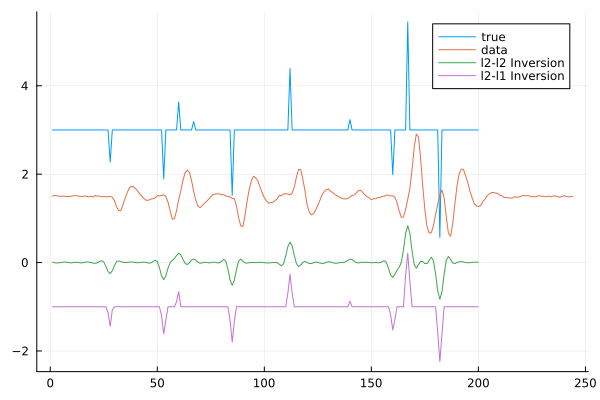

In [60]:
# Seismic Deconvolution Example

# seismicwavelet

w = seismic_wavelet(f0=34.0,dt=0.002)

# Reflectivity

M = 200; N = 10; x = zeros(M); x[randperm(M)[1:N]] = randn(N) 

# The wavelet convolution operator 

C = conv1d_op(w) 

# Make data and add noise 

y = C*x; y = y + 0.01*randn(size(y))

# Inversion with DLS 

μ = 0.1
x1  = cgls(C, y, μ, zeros(200); tol=1e-9, max_iter=140)

# Inversion via ISTA 

e = opnorm_power(C,randn(200)) # Max eigen of C'C 

ν = 0.98/e^2.  # Step size 

x2 = ista(C, y, zeros(200), μ, ν; niter=200, verbose=false);

plot(x.+3,label="true")
plot!(y.+1.5,label="data")
plot!(x1, label="l2-l2 Inversion")
plot!(x2.-1, label="l2-l1 Inversion")

